In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
import cv2
import glob
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

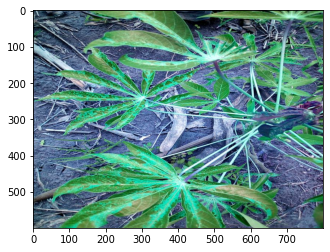

In [2]:
img_example=cv2.imread('../input/iitgai-hackathon-2-2021-2022/train_images/train_images/1000201771.jpg')
plt.imshow(img_example)

In [3]:
img_example.shape

(600, 800, 3)

In [4]:
df=pd.read_csv("../input/iitgai-hackathon-2-2021-2022/train_data.csv")
df.head()

,image_id,label
0,6103,3
1,218377,1
2,336550,3
3,469487,1
4,690163,3


<AxesSubplot:xlabel='label', ylabel='count'>

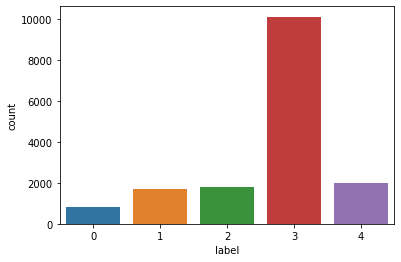

In [5]:
sns.countplot(x="label",data=df)

In [6]:
df_copy=df['label'].astype('object')
df_copy.describe()

count     16416
unique        5
top           3
freq      10097
Name: label, dtype: int64

In [7]:
df=df.astype({'image_id': 'str','label':'str'})
df.head()
df.dtypes

image_id    object
label       object
dtype: object

In [8]:
df['image_id']=df['image_id']+'.jpg'

In [9]:
df.head()

,image_id,label
0,6103.jpg,3
1,218377.jpg,1
2,336550.jpg,3
3,469487.jpg,1
4,690163.jpg,3


In [10]:
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(df,test_size=0.2)

In [11]:
from keras.preprocessing.image import ImageDataGenerator as IDG
from keras.preprocessing.image import load_img, img_to_array
train_datagen=IDG(rescale=1/255,rotation_range=90,shear_range=0.1,horizontal_flip=True,
                  zoom_range=0.2,brightness_range=[0.4,1.0],height_shift_range=0.2,width_shift_range=0.2)
test_datagen=IDG(rescale=1/255)
train_df=train_datagen.flow_from_dataframe(train_df,directory="../input/iitgai-hackathon-2-2021-2022/train_images/train_images",
                                           x_col="image_id",y_col="label",target_size=(300,300))
valid_df=test_datagen.flow_from_dataframe(valid_df,directory="../input/iitgai-hackathon-2-2021-2022/train_images/train_images",
                                           x_col="image_id",y_col="label",target_size=(300,300))


Found 13132 validated image filenames belonging to 5 classes.
Found 3284 validated image filenames belonging to 5 classes.


In [12]:
test_df=test_datagen.flow_from_directory("../input/iitgai-hackathon-2-2021-2022/test_images",shuffle=False,
                                         target_size=(300,300))

Found 4981 images belonging to 1 classes.


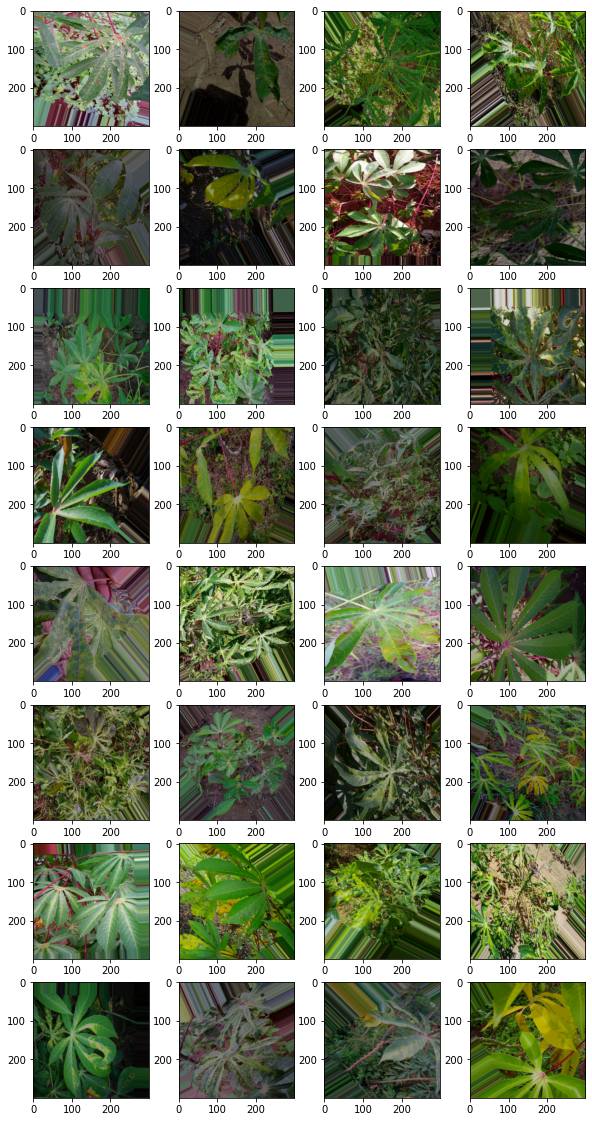

In [13]:
batch_train=next(train_df)
plt.figure(figsize=(10,20))
for i in range(32):
    plt.subplot(8,4,i+1)
    plt.imshow(batch_train[0][i])
plt.show()  

In [14]:
base_model=tf.keras.applications.MobileNet(include_top=False,weights='imagenet',input_shape=(224,224,3))
model=Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(5,activation='softmax'))    

2021-12-18 07:39:08.165871: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-18 07:39:08.275793: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-18 07:39:08.276821: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-18 07:39:08.278346: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

17235968/17225924 [==============================] - 0s 0us/step


In [15]:
save_callback=tf.keras.callbacks.ModelCheckpoint(filepath='./checkpoint',save_weights_only=False,monitor='val_loss',
                                             save_best_only=True)
checkpoint_path="./checkpoint"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [16]:
early_stop= EarlyStopping(
                                monitor = "val_accuracy",
                                min_delta=0.001,
                                patience=5,
                                verbose=1,
                                mode="max")

In [17]:
reduce_lr = ReduceLROnPlateau(
                                monitor="val_accuracy",
                                factor=0.1,
                                patience=2,
                                verbose=1,
                                min_delta=0.0001)

In [18]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
for layers in base_model.layers:
    layers.trainable=False
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               131200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               5

In [19]:
model.fit(train_df,validation_data=valid_df,epochs=30,steps_per_epoch=train_df.n//train_df.batch_size,validation_steps=valid_df.n//valid_df.batch_size,verbose=1,callbacks=[save_callback,early_stop,reduce_lr])

2021-12-18 07:39:13.967693: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2021-12-18 07:39:19.589177: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


410/410 [==============================] - 605s 1s/step - loss: 0.9470 - accuracy: 0.6858 - val_loss: 1.7196 - val_accuracy: 0.5499


2021-12-18 07:49:26.638505: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Epoch 2/30
410/410 [==============================] - 483s 1s/step - loss: 0.6246 - accuracy: 0.7822 - val_loss: 0.6960 - val_accuracy: 0.7466
Epoch 3/30
410/410 [==============================] - 481s 1s/step - loss: 0.5683 - accuracy: 0.8024 - val_loss: 0.6122 - val_accuracy: 0.8030
Epoch 4/30
410/410 [==============================] - 485s 1s/step - loss: 0.5260 - accuracy: 0.8153 - val_loss: 0.6837 - val_accuracy: 0.7678
Epoch 5/30
410/410 [==============================] - 505s 1s/step - loss: 0.5108 - accuracy: 0.8236 - val_loss: 0.7129 - val_accuracy: 0.7613

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 6/30
410/410 [==============================] - 504s 1s/step - loss: 0.4444 - accuracy: 0.8460 - val_loss: 0.3941 - val_accuracy: 0.8686
Epoch 7/30
410/410 [==============================] - 499s 1s/step - loss: 0.4186 - accuracy: 0.8555 - val_loss: 0.4005 - val_accuracy: 0.8649
Epoch 8/30
410/410 [==============================] - 498s 1

In [20]:
pred=model.predict(test_df,verbose=1)
np.save('densenet', pred)

156/156 [==============================] - 99s 628ms/step


In [21]:
predictions = np.argmax(pred, axis=1)
filenames   = test_df.filenames

In [22]:
result=pd.DataFrame({"image_id":filenames,"label":predictions})
result['image_id']=result['image_id'].map(lambda x: x.lstrip('test_images/').rstrip('.jpg'))
result['label']=result['label'].astype(int)
result.to_csv("results.csv",index=False)
result.head()

,image_id,label
0,3286502189,3
1,3286807982,3
2,3287098987,3
3,3287200393,3
4,3287300042,3


In [23]:
result.label.unique()

array([3, 1, 4, 2, 0])